<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2020cnps_tSNE_for_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# word2vec を tSNE 視覚化

<div align='right'>
<a href='mailto:asakawa@ieee.org'>Shin Aasakawa</a>, all rights reserved.<br>
Date: 09/Mar/2020<br>
 MIT license
</div>

References: 
- Paper: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
- Distill: https://distill.pub/2016/misread-tsne/
- wikipedia: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
- wikipedia.ja: https://ja.wikipedia.org/wiki/T%E5%88%86%E5%B8%83%E5%9E%8B%E7%A2%BA%E7%8E%87%E7%9A%84%E8%BF%91%E5%82%8D%E5%9F%8B%E3%82%81%E8%BE%BC%E3%81%BF%E6%B3%95



In [0]:
# 必要なパッケージの読み込み
# -*- coding: utf-8 -*-
import time
import numpy as np
import os
import sys
import pickle
import scipy
import gensim  # https://radimrehurek.com/gensim/
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import seaborn as sns


In [0]:
# 訓練済みのファイルを入手
# 下記のデータは浅川が日本語ウィキペディアを使って訓練したデータです

!wget http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz
#!wget http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_sgns.bin.gz
#!wget http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid300_win20_neg20_sgns.bin.gz
#!wget http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz

--2020-03-09 12:25:06--  http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz
Resolving www.cis.twcu.ac.jp (www.cis.twcu.ac.jp)... 160.13.90.21
Connecting to www.cis.twcu.ac.jp (www.cis.twcu.ac.jp)|160.13.90.21|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz [following]
--2020-03-09 12:25:07--  https://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz
Connecting to www.cis.twcu.ac.jp (www.cis.twcu.ac.jp)|160.13.90.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1369049082 (1.3G) [application/x-gzip]
Saving to: ‘2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz.1’

2017Jul_jawiki-waka 100%[===================>]   1.27G  34.1MB/s    in 37s     

2020-03-09 12:25:44 (34.8 MB/s) - ‘2017Jul_jawiki-wakati_neologd_hid200_win

In [0]:
# word2vec の実行モジュールに読み込みます
w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
#w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg10_cbow.bin.gz'
#w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_sgns.bin.gz'
#w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg10_sgns.bin.gz'
asakawa_w2v_file = os.path.join('.', w2v_file)
asakawa_w2v = KeyedVectors.load_word2vec_format(asakawa_w2v_file, 
                                                encoding='utf-8', 
                                                unicode_errors='replace',
                                                binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# 確認
#help(asakawa_w2v.get_vector)
asakawa_w2v.get_vector('頻度').shape # (200,)  これは word2vec の次元数

(200,)

In [0]:
# tlpa のデータを GitHub から取得する
!wget 'https://github.com/ShinAsakawa/ShinAsakawa.github.io/blob/master/tlpa.pkl?raw=true'
!mv 'tlpa.pkl?raw=true' tlpa.pkl

--2020-03-09 12:38:56--  https://github.com/ShinAsakawa/ShinAsakawa.github.io/blob/master/tlpa.pkl?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ShinAsakawa/ShinAsakawa.github.io/raw/master/tlpa.pkl [following]
--2020-03-09 12:38:57--  https://github.com/ShinAsakawa/ShinAsakawa.github.io/raw/master/tlpa.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/tlpa.pkl [following]
--2020-03-09 12:38:57--  https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/tlpa.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... conn

In [0]:
# 取得した tlpa データの読み込み
with open('tlpa.pkl','rb') as f:
    tlpa = pickle.load(f)

In [0]:
 # tlpa の親密度とカテゴリーの表記情報を読み込む
tlpa_fam = [tlpa[k]['Fam'] for k in tlpa.keys()]
tlpa_cat = [tlpa[k]['Cat'] for k in tlpa.keys()]
print(set(tlpa_fam), len(tlpa_fam), set(tlpa_cat), len(tlpa_fam))

{'H', 'L'} 200 {'F', 'V', 'B', 'P', 'C', 'I', 'A', 'D', 'E', 'T'} 200


In [0]:
# 印刷して確認
print(tlpa_fam)
print(tlpa_cat)

['H', 'H', 'H', 'L', 'L', 'H', 'L', 'L', 'H', 'L', 'H', 'H', 'L', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'H', 'H', 'L', 'L', 'L', 'H', 'L', 'L', 'L', 'H', 'L', 'H', 'H', 'L', 'H', 'L', 'L', 'H', 'L', 'H', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'L', 'H', 'H', 'L', 'H', 'H', 'L', 'H', 'L', 'H', 'L', 'H', 'L', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'L', 'H', 'H', 'H', 'H', 'H', 'H', 'L', 'L', 'H', 'L', 'L', 'L', 'H', 'H', 'H', 'L', 'H', 'L', 'H', 'L', 'L', 'L', 'L', 'L', 'H', 'H', 'L', 'H', 'H', 'H', 'L', 'L', 'H', 'L', 'L', 'H', 'L', 'L', 'L', 'H', 'H', 'H', 'L', 'L', 'H', 'H', 'L', 'H', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'L', 'H', 'L', 'H', 'L', 'H', 'H', 'L', 'H', 'L', 'H', 'H', 'L', 'H', 'L', 'L', 'H', 'L', 'L', 'H', 'H', 'L', 'H', 'H', 'L', 'L', 'H', 'L', 'H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'H', 'H', 'H', 'L', 'L', 'L', 'H', 'L', 'L', 'H', 'L', 'H', 'H', 'L', 'H', 'L', 'L', 'L', 'H', 'H', 'L', 'H', 'H', 'L', 'L', 'L', 'H', 'H', 'L', 'H']

In [0]:
# 以下の作業は，tlpa データと word2vec のデータが不一致だったので強制的に書き換えています
tlpa[106]['label'] = "刺身"
tlpa[116]['label'] = "すりこ木"
tlpa[123]['label'] = "ぶどう"
tlpa[139]['label'] = "畳"
tlpa[162]['label'] = "タイヤキ"
tlpa[188]['label'] = "タツノオトシゴ"

In [0]:
# ここがポイントで，tlpa のデータと word2vec のデータを結合します
w2v_vect = np.zeros([200,200])
for k in tlpa.keys():
    word = tlpa[k]['label']
    w2v_vect[k-1] = np.copy(asakawa_w2v[word])
    if k % 10 == 0:
        print('{0:03d} {1:s}'.format(k, word))
    else:
        print('{0:03d} {1:s}'.format(k, word), end=", ")


001 バス, 002 緑, 003 桜, 004 のり巻き, 005 五重塔, 006 コップ, 007 ごぼう, 008 土踏まず, 009 風呂, 010 ヒトデ
011 ハム, 012 兎, 013 ロープウエイ, 014 学校, 015 ちりとり, 016 縁側, 017 歯, 018 ネギ, 019 あじさい, 020 灰色
021 天井, 022 鍵, 023 肌色, 024 ワニ, 025 電車, 026 顔, 027 松, 028 ガードレール, 029 柿, 030 ちまき
031 信号, 032 すすき, 033 じょうろ, 034 コンセント, 035 天ぷら, 036 中指, 037 ヨット, 038 ピンク, 039 ふくろう, 040 みかん
041 柱, 042 角砂糖, 043 犬, 044 かご, 045 バラ, 046 鍋, 047 まぶた, 048 くるみ, 049 黒, 050 デパート
051 カーネーション, 052 城, 053 蟻, 054 豆腐, 055 ドライバー, 056 紺, 057 階段, 058 戦車, 059 人参, 060 背中
061 鏡餅, 062 スプーン, 063 朝顔, 064 金, 065 足, 066 ふすま, 067 蛇, 068 レモン, 069 公園, 070 乳母車
071 床, 072 藤, 073 ピンセット, 074 トラック, 075 苺, 076 黄土色, 077 銭湯, 078 ナマズ, 079 そば, 080 お腹
081 オレンジ, 082 バター, 083 工場, 084 鳩, 085 電卓, 086 喉仏, 087 チューリップ, 088 白菜, 089 トラクター, 090 廊下
091 パトカー, 092 押入れ, 093 鉛筆, 094 目尻, 095 芋, 096 吊り橋, 097 赤, 098 かき氷, 099 豹, 100 サボテン
101 ピラミッド, 102 サイ, 103 目, 104 ひまわり, 105 はたき, 106 刺身, 107 玄関, 108 トマト, 109 黄緑, 110 三輪車
111 鶏, 112 つむじ, 113 アスパラガス, 114 ドア, 115 銀色, 116 すりこ木, 117 ウイスキー, 118 梅, 11

In [0]:
# tSNE の前段階として主成分分析を実施します
#type(w2v_vect)
#w2v_vect.shape
tlpa_pca = PCA(n_components=3)
tlpa_pca_result = tlpa_pca.fit_transform(w2v_vect)
pca1 = tlpa_pca_result[:,0]
pca2 = tlpa_pca_result[:,1] 
pca3 = tlpa_pca_result[:,2]
print('Explained variation per principal component: {}'.format(tlpa_pca.explained_variance_ratio_))

Explained variation per principal component: [0.09399472 0.07608341 0.06780095]


In [0]:
# 結果の再現性を保証するため，乱数の種を指定します。この作業は省略可です
np.random.seed(2)
#rndperm = np.random.permutation(w2v_vect.shape[0])

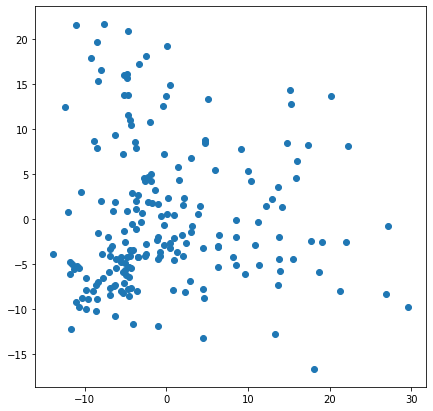

In [0]:
# 主成分分析の結果を画面に表示
x_inch = 7; y_inch = 7
fig = plt.figure(figsize=(x_inch, y_inch))
plt.scatter(pca1,pca2)

In [0]:
# 主成分分析結果をカテゴリごとに色分けして描画
df = pd.DataFrame(tlpa_pca_result, columns=["pca1", "pca2", "pca3"])
#help(sns.scatterplot)
df["fam"] = tlpa_fam; df["cat"] = tlpa_cat

T:乗り物, C:色, P:植物, F:加工食品, E:建造物, D:道具, V:野菜果物，B:身体部位, I:屋内部位, A:動物

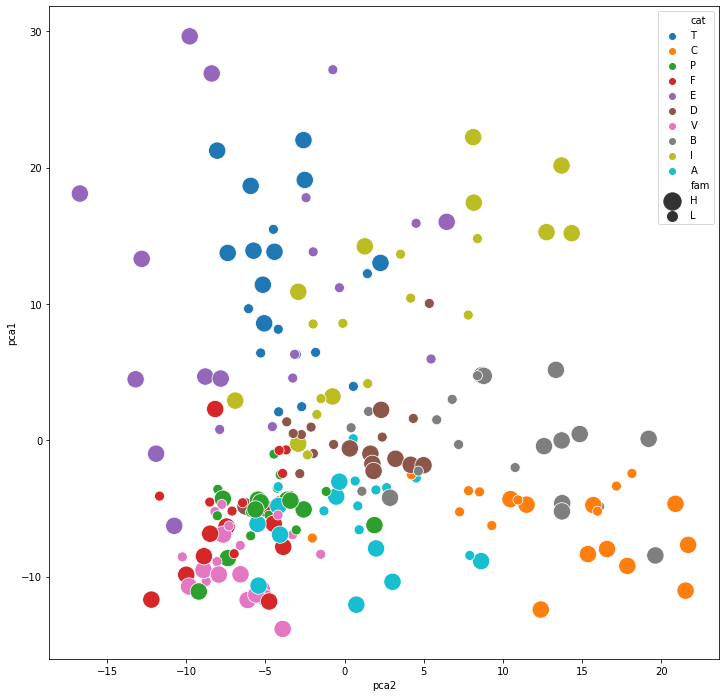

In [0]:
plt.figure(figsize=(12,12))
ax = sns.scatterplot(x="pca2", y="pca1", data=df, hue="cat", size="fam", sizes=(100,300)) # , legend="full")
#T:乗り物, C:色, P:植物, F:加工食品, E:建造物, D:道具, V:野菜果物，B:身体部位, I:屋内部位, A:動物

In [0]:
# 上記の図を pdf ファイルとして保存
fig = ax.get_figure()
fig.savefig('tlpa_pca2-3.pdf')

# ここから先が tSNE の計算

In [0]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)  # tSNE の定義
tsne_results = tsne.fit_transform(w2v_vect)  # tSNE による word2vec の可視化
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 8.936858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.719574
[t-SNE] KL divergence after 500 iterations: 0.885893
t-SNE done! Time elapsed: 0.7565443515777588 seconds


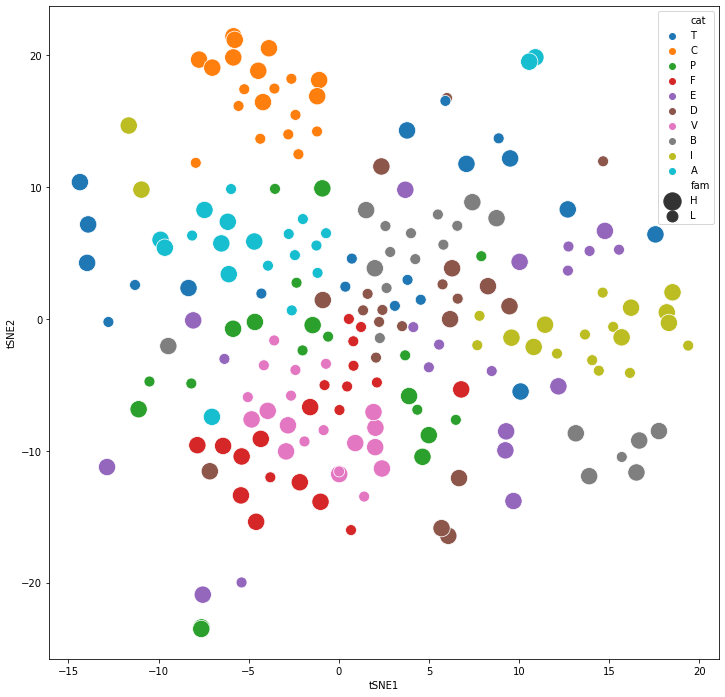

In [0]:
# tSNE 結果の描画
df_subset = df.copy()
#df_subset['pca-one'] = pca_result[:,0]
#df_subset['pca-two'] = pca_result[:,1] 
#df_subset['pca-three'] = pca_result[:,2]

df_subset['tSNE1'] = tsne_results[:,0]
df_subset['tSNE2'] = tsne_results[:,1]

plt.figure(figsize=(12,12))
ax = sns.scatterplot(x="tSNE1", y="tSNE2", hue="cat", size="fam",
    data=df_subset, sizes=(120,300)
)
fig = ax.get_figure()
fig.savefig('tlpa_tSNE.pdf')  # 結果の保存